### **Load Libraries**

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import os, shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow_hub as hub
import time

# Data augmentation and model preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


### **Define Paths & Load Data**

In [ ]:
# Define paths
BASE_PATH = "/content/drive/MyDrive/chest_xray"
TRAIN_PATH = os.path.join(BASE_PATH, "train")
TEST_PATH = os.path.join(BASE_PATH, "test")

labels = ['PNEUMONIA', 'NORMAL']
img_size = 224  # EfficientNet-B4 optimal input size

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                data.append([img_path, label])
            except Exception as e:
                print(e)
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data
train = get_data(TRAIN_PATH)
test = get_data(TEST_PATH)

print(train.head(5))
print(f"\nThe shape of The Train data is: {train.shape}")
print(f"The shape of The Test data is: {test.shape}")


                                            filepath      label
0  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
1  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
2  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
3  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA
4  /content/drive/MyDrive/chest_xray/train/PNEUMO...  PNEUMONIA

The shape of The Train data is: (5233, 2)
The shape of The Test data is: (625, 2)


In [ ]:
# Create datasets and compute class weights
IMAGE_SIZE = (224, 224)  # input size

# Load training / validation / test sets (no shuffling for test)
print('\nTraining Images:')
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='training',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nValidation Images:')
validation_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    validation_split=0.1,
    subset='validation',
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

print('\nTesting Images:')
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    seed=123,
    image_size=IMAGE_SIZE,
    batch_size=32)

# Class names and label encoder (simple mapping)
train_labels = train_ds.class_names
test_labels = test_ds.class_names
validation_labels = validation_ds.class_names

class_labels = ['NORMAL', 'PNEUMONIA']
label_encoder = LabelEncoder()
label_encoder.fit(class_labels)

# Apply EfficientNet preprocessing to the datasets
# image_dataset_from_directory yields images in 0-255 range; preprocess_input expects that.
preprocess_fn = tf.keras.applications.efficientnet.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (preprocess_fn(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_fn(x), y))

# Count files
def retrieveNumberOfFiles(path):
    return len([f for f in os.listdir(os.path.join(path, "NORMAL")) if f.endswith('.jpeg')] +
               [f for f in os.listdir(os.path.join(path, "PNEUMONIA")) if f.endswith('.jpeg')])

totalTrain = retrieveNumberOfFiles(TRAIN_PATH)
totalTest = retrieveNumberOfFiles(TEST_PATH)

# Compute class weights using the standard per-class inverse-frequency formula
allTrainFiles = [os.path.join(TRAIN_PATH, "NORMAL", f) for f in os.listdir(os.path.join(TRAIN_PATH, "NORMAL"))] + \
                [os.path.join(TRAIN_PATH, "PNEUMONIA", f) for f in os.listdir(os.path.join(TRAIN_PATH, "PNEUMONIA"))]

train_counts = {
    0: sum(1 for p in allTrainFiles if "NORMAL" in p),
    1: sum(1 for p in allTrainFiles if "PNEUMONIA" in p)
}
total_samples = train_counts[0] + train_counts[1]
num_classes = 2
classWeight = {
    0: total_samples / (num_classes * train_counts[0]),
    1: total_samples / (num_classes * train_counts[1])
}
print("Class weights:", classWeight)


Training Images:
Found 5232 files belonging to 2 classes.
Using 4709 files for training.

Validation Images:
Found 5232 files belonging to 2 classes.
Using 523 files for validation.

Testing Images:
Found 624 files belonging to 2 classes.
Class weights: {0: 1.9395848776871756, 1: 0.6736611740473738}


In [ ]:
# Data generators and augmentation
BATCH_SIZE = 32
INIT_LR = 1e-4
EPOCHS = 15

# EfficientNet-specific preprocessing for images loaded by ImageDataGenerator

# Augmentation for training (keeps images realistic)
trainAug = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode="nearest")

# Validation / test generator with the same preprocessing but no augmentation
valAug = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Use binary labels (single output neuron -> sigmoid)
trainGen = trainAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="binary",       # binary labels: 0 or 1
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    shuffle=True,
    batch_size=BATCH_SIZE)

validationGen = valAug.flow_from_directory(
    TRAIN_PATH,
    class_mode="binary",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)

testGen = valAug.flow_from_directory(
    TEST_PATH,
    class_mode="binary",
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    shuffle=False,
    batch_size=BATCH_SIZE)


Found 5232 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### **Build Model**

In [ ]:
# Build the EfficientNet-B4 model
def build_efficientnet_b4_match_nih(input_shape=(224, 224, 3)):
    # Base EfficientNet
    base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=input_shape)

    # Fine-tune the backbone (allow weights to update)
    base_model.trainable = True

    # Model input expects images already preprocessed by the data pipeline
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)     # feed directly into base model
    x = GlobalAveragePooling2D()(x)

    # Compact classification head
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # single prob for positive class

    model = Model(inputs=inputs, outputs=output)
    return model

model = build_efficientnet_b4_match_nih(input_shape=(224, 224, 3))

# Compile with Adam(1e-4) and binary cross-entropy
print("Compiling model")
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

model.summary()

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Compiling model


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 7, 7, 1792)     │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1792)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,133,088 (69.17 MB)

 Trainable params: 18,007,881 (68.69 MB)

 Non-trainable params: 125,207 (489.09 KB)

### **Train Model**

In [ ]:
# Add callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)

# Callbacks
os.makedirs("/content/drive/MyDrive/chest_xray/EfficientNetB4_New", exist_ok=True)
MCName = os.path.sep.join(["/content/drive/MyDrive/chest_xray/EfficientNetB4_New", "EfficientNetB4_weights-{epoch:03d}-{val_loss:.4f}.keras"])
checkpoint = ModelCheckpoint(
    MCName,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)
callbacks = [checkpoint, reduce_lr, early_stopping]

# Train model
print("Model Fitting")
start_time = time.time()

# Calculate steps per epoch and validation steps correctly
import math
steps_per_epoch = math.ceil(trainGen.samples / BATCH_SIZE)
validation_steps = math.ceil(validationGen.samples / BATCH_SIZE) # Use validationGen.samples for validation steps

history = model.fit(
    x=trainGen,
    steps_per_epoch=steps_per_epoch,
    validation_data=validationGen,
    validation_steps=validation_steps,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=EPOCHS)

training_time = (time.time() - start_time) / 60
print(f"\nTraining completed in {training_time:.2f} minutes")

Model Fitting
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8170 - loss: 0.3614
Epoch 1: val_loss improved from inf to 0.09173, saving model to /content/drive/MyDrive/chest_xray/EfficientNetB4_New/EfficientNetB4_weights-001-0.0917.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 16388s 100s/step - accuracy: 0.8175 - loss: 0.3605 - val_accuracy: 0.9679 - val_loss: 0.0917 - learning_rate: 1.0000e-04
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9575 - loss: 0.0979
Epoch 2: val_loss improved from 0.09173 to 0.08386, saving model to /content/drive/MyDrive/chest_xray/EfficientNetB4_New/EfficientNetB4_weights-002-0.0839.keras
164/164 ━━━━━━━━━━━━━━━━━━━━ 1646s 10s/step - accuracy: 0.9576 - loss: 0.0978 - val_accuracy: 0.9673 - val_loss: 0.0839 - learning_rate: 1.0000e-04
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9743 - loss: 0.0568
Epoch 3: val_loss did not improve from 0.08386
164/164 ━━━━━━━━━━━━━━━━━━━━ 1653s 10s/step - accuracy: 0.9743 - los

### **Evaluation**


Evaluating model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 190s 10s/step - accuracy: 0.9242 - loss: 0.2146
Test Accuracy: 95.19%
Test Loss: 0.1413


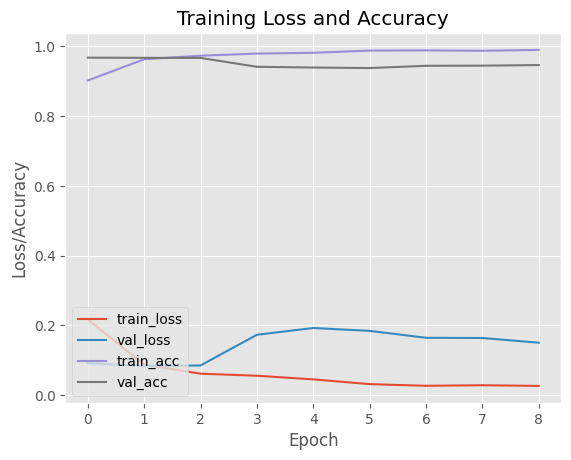

In [ ]:
# Evaluate model
print("\nEvaluating model...")
test_results = model.evaluate(testGen, batch_size=BATCH_SIZE)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history.history["accuracy"])), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history.history["val_accuracy"])), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()


Evaluating model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9242 - loss: 0.2146
Test Accuracy: 95.19%
Test Loss: 0.1413
20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.96      0.91      0.93       234
   PNEUMONIA       0.95      0.98      0.96       390

    accuracy                           0.95       624
   macro avg       0.95      0.94      0.95       624
weighted avg       0.95      0.95      0.95       624


Confusion Matrix:
[[212  22]
 [  8 382]]
Accuracy: 0.9519
Sensitivity: 0.9795
Specificity: 0.9060


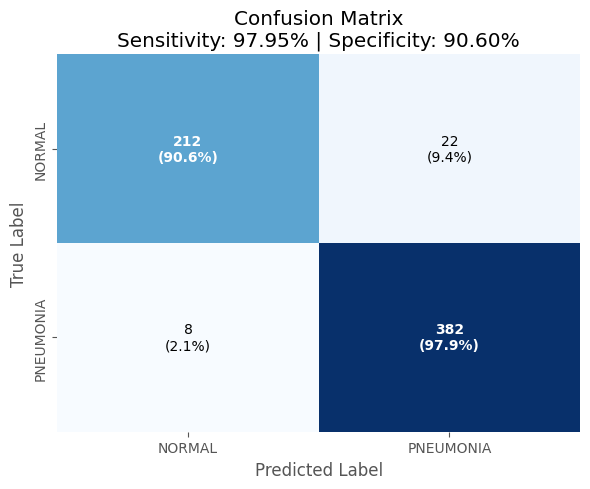

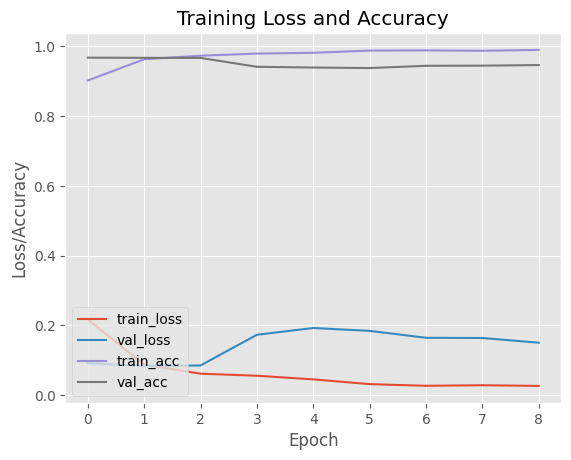

In [ ]:
# Evaluate model
import math
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("\nEvaluating model...")
test_steps = math.ceil(testGen.samples / BATCH_SIZE)
test_results = model.evaluate(testGen, steps=test_steps)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
predIdxs = model.predict(testGen, steps=test_steps)
# handle single-output sigmoid correctly: flatten probs and threshold
pred_probs = np.array(predIdxs).ravel()
predTest = (pred_probs >= 0.5).astype(int)

# ensure target names are ordered by the generator's class indices
class_names = [k for k, v in sorted(testGen.class_indices.items(), key=lambda kv: kv[1])]

print("\nClassification Report:")
print(classification_report(testGen.classes, predTest, target_names=class_names, zero_division=0))

# Confusion matrix
cm = confusion_matrix(testGen.classes, predTest)
total = cm.sum() if cm.size > 0 else 0
acc = ((cm[0, 0] + cm[1, 1]) / total) if total > 0 else 0.0
# Calculate Sensitivity and Specificity (guard against zero division)
sensitivity = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) if (cm[1, 0] + cm[1, 1]) > 0 else 0.0
specificity = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) if (cm[0, 0] + cm[0, 1]) > 0 else 0.0

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(acc))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with class-wise percentages
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names,
                cbar=False)

# Add annotations with counts and class-wise percentages
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        percentage = (cm[i, j] / row_sum) * 100 if row_sum > 0 else 0
        is_correct = (i == j)
        text = f"{cm[i, j]}\n({percentage:.1f}%)"
        ax.text(j + 0.5, i + 0.5, text,
               ha='center', va='center',
               color='white' if is_correct else 'black',
               weight='bold' if is_correct else 'normal')

# Calculate metrics for title (safe divisions)
total = cm.sum() if cm.size > 0 else 0
acc = ((cm[0, 0] + cm[1, 1]) / total) if total > 0 else 0.0
sensitivity = (cm[1, 1] / (cm[1, 0] + cm[1, 1])) if (cm[1, 0] + cm[1, 1]) > 0 else 0.0
specificity = (cm[0, 0] / (cm[0, 0] + cm[0, 1])) if (cm[0, 0] + cm[0, 1]) > 0 else 0.0

plt.title(f"Confusion Matrix\nSensitivity: {sensitivity:.2%} | Specificity: {specificity:.2%}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot training history
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, len(history.history["loss"])), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, len(history.history["val_loss"])), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, len(history.history["accuracy"])), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, len(history.history["val_accuracy"])), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()

### **Evaluation (Best Saved Model)**

best model = /content/drive/MyDrive/chest_xray/EfficientNetB4_New/EfficientNetB4_weights-002-0.0839.keras

Evaluating model...
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.9242 - loss: 0.2146
Test Accuracy: 95.19%
Test Loss: 0.1413
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step

Classification Report:
              precision    recall  f1-score   support

      NORMAL     0.9636    0.9060    0.9339       234
   PNEUMONIA     0.9455    0.9795    0.9622       390

    accuracy                         0.9519       624
   macro avg     0.9546    0.9427    0.9481       624
weighted avg     0.9523    0.9519    0.9516       624


Confusion Matrix:
[[212  22]
 [  8 382]]
Accuracy: 0.9519
Sensitivity: 0.9795
Specificity: 0.9060


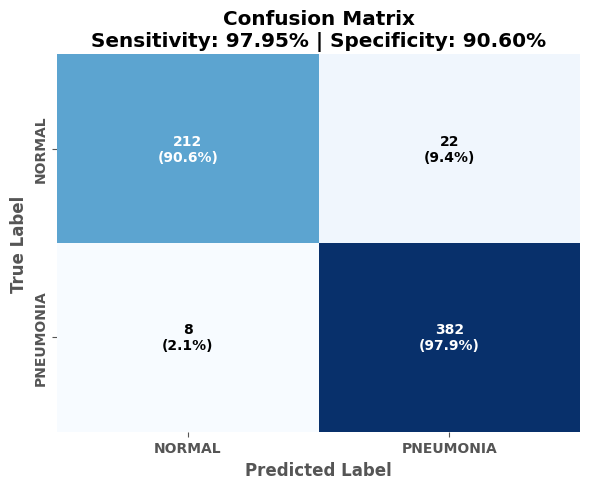

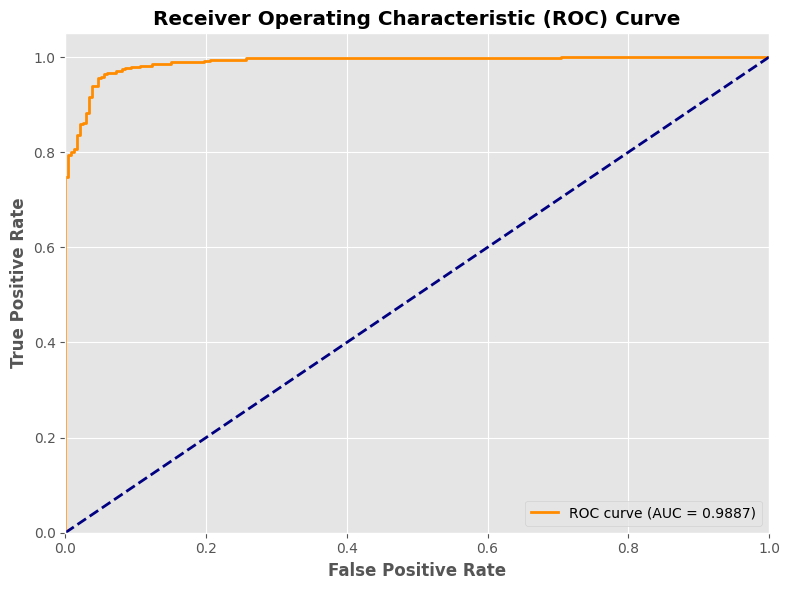

In [ ]:
# Full evaluation using the best saved model
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

# use the best saved model directly (user-provided path)
best_model = "/content/drive/MyDrive/chest_xray/EfficientNetB4_New/EfficientNetB4_weights-002-0.0839.keras"
print("best model =", best_model)
model = tf.keras.models.load_model(best_model)

# evaluate on test generator
test_steps = math.ceil(testGen.samples / BATCH_SIZE)
print("\nEvaluating model...")
test_results = model.evaluate(testGen, steps=test_steps, verbose=1)
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))
print("Test Loss: {:.4f}".format(test_results[0]))

# Predictions and classification report
# Note: model has a single sigmoid output, so we threshold probabilities rather than argmax.
predIdxs = model.predict(testGen, steps=test_steps, verbose=1)  # raw probs shape (N,1)
pred_probs = np.array(predIdxs).ravel()                         # flatten to (N,)
predTest = (pred_probs >= 0.5).astype(int)                      # binary predictions

# Ensure class names follow generator mapping (index order)
class_names = [k for k, v in sorted(testGen.class_indices.items(), key=lambda kv: kv[1])]

print("\nClassification Report:")
# keep the "type" of call you showed but pass ordered class names and guard zero-division
print(classification_report(testGen.classes, predTest, target_names=class_names, zero_division=0, digits=4))

# Confusion matrix and derived metrics
cm = confusion_matrix(testGen.classes, predTest)
total = cm.sum() if cm.size > 0 else 0

# unpack safely for binary case
if cm.shape == (2, 2):
    tn, fp, fn, tp = cm.ravel()
else:
    tn = fp = fn = tp = 0

accuracy = ((tp + tn) / total) if total > 0 else 0.0
sensitivity = (tp / (tp + fn)) if (tp + fn) > 0 else 0.0   # recall for positive class
specificity = (tn / (tn + fp)) if (tn + fp) > 0 else 0.0

print("\nConfusion Matrix:")
print(cm)
print("Accuracy: {:.4f}".format(accuracy))
print("Sensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

# Plot confusion matrix with bold labels and annotations
plt.figure(figsize=(6, 5))
ax = sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False,
                 xticklabels=class_names, yticklabels=class_names)

# Bold tick labels
ax.set_xticklabels(class_names, fontweight='bold')
ax.set_yticklabels(class_names, fontweight='bold')

# Annotate counts + class-wise (row-wise) percentages in bold
for i in range(cm.shape[0]):
    row_sum = cm[i, :].sum()
    for j in range(cm.shape[1]):
        cnt = cm[i, j]
        pct = (cnt / row_sum * 100) if row_sum > 0 else 0.0
        text = f"{cnt}\n({pct:.1f}%)"
        is_correct = (i == j)
        color = 'white' if is_correct else 'black'
        ax.text(j + 0.5, i + 0.5, text, ha='center', va='center', color=color, weight='bold')

# Title
plt.title(f"Confusion Matrix\nSensitivity: {sensitivity:.2%} | Specificity: {specificity:.2%}", fontweight='bold')
plt.xlabel("Predicted Label", fontweight='bold')
plt.ylabel("True Label", fontweight='bold')
plt.tight_layout()
plt.show()




# AUC Curve
fpr, tpr, _ = roc_curve(testGen.classes, pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Model Size**

In [ ]:
import os

# Path to the best saved model file
best_model_path = "/content/drive/MyDrive/chest_xray/EfficientNetB4_New/EfficientNetB4_weights-002-0.0839.keras"

# Get the file size in bytes
file_size_bytes = os.path.getsize(best_model_path)

# Convert bytes to megabytes for readability
file_size_mb = file_size_bytes / (1024 * 1024)

print(f"Size of the best saved model: {file_size_mb:.2f} MB")

Size of the best saved model: 208.44 MB
